# NDVI Calculation

In [1]:
import fiona
import sentinelsat
import ipywidgets as widgets
import numpy as np
import os
import time
import lithops
import random
import rasterio
import re
import tempfile
import zipfile
import subprocess
import glob
import multiprocessing as mp
import json
from rio_cogeo import cogeo

from collections import defaultdict
from datetime import date
from fiona.io import ZipMemoryFile
from matplotlib import pyplot as plt
from rasterio.io import MemoryFile
from zipfile import ZipFile
from ipyleaflet import Map, basemaps, basemap_to_tiles
from lithops import Storage

from cloudbutton_geospatial.utils import notebook as notebook_utils
from cloudbutton_geospatial.io_utils.ndvi import get_ndvi_params, ndvi_calculation, ndvi_tile_sentinel, get_subset_raster, lonlat_to_utm, get_poly_within
from cloudbutton_geospatial.io_utils.plot import tiff_overview, plot_map

os.environ['CURL_CA_BUNDLE'] = '/etc/ssl/certs/ca-certificates.crt'

Set the environmental variables *SENTINEL_USERNAME* and *SENTINEL_PASSWORD* to match your Sentinel-2 credentials. You can register and access data for free at https://sentinel.esa.int/web/sentinel/sentinel-data-access/registration:

In [2]:
SENTINEL_USERNAME = ''
SENTINEL_PASSWORD = ''
STORAGE_BUCKET = 'geospatial-usecase'
COMPUTE_BACKEND = 'ibm_cf'
STORAGE_BACKEND = 'ibm_cos'
RUNTIME = 'jsampe/lithops-ibmcf-geo-ndvi-v38:02'

In [3]:
%matplotlib inline

In [4]:
cloud_storage = Storage(backend=STORAGE_BACKEND)

## Input parameters

Select the date interval in which tiles will be processed:

In [5]:
from_day, to_day = notebook_utils.pick_date_range()

DatePicker(value=datetime.date(2021, 9, 1), description='From day')

DatePicker(value=datetime.date(2021, 9, 4), description='To day')

Select the tile's cloud percentage threshold:

In [6]:
percentage = notebook_utils.pick_percentage_slider()
from_day.value

IntSlider(value=15, continuous_update=False, description='Percentage of cloudiness')

datetime.date(2021, 9, 1)

Select the area which delimites the tiles you want to process (left click to mark a point in the map, right click to erase current selection):

In [7]:
map_region = notebook_utils.MapRegion()

Map(center=[41.1169, 1.2545], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoo…

## Get Sentinel-2 metadata

In [8]:
locations = map_region.get_region()

# Tarragona data
locations = [[1.5481363013595886, 41.16508628430497],
 [0.8177319989996914, 40.62111912603713],
 [0.6008074129604647, 40.60652433834119],
 [0.4552757286556909, 40.868742532626996],
 [0.3811369460853299, 41.03883697553436],
 [0.427816920296289, 41.247740935856484],
 [0.694167361382423, 41.33441592882952],
 [1.097811844265526, 41.39831645175795],
 [1.452030472101722, 41.365343372983396],
 [1.5481363013595886, 41.16508628430497]]


# debug
#locations = [[-1.32110595703125, 37.57329031970199],
#   [-2.0681762695312504, 37.684227882053044],
#   [-1.636962890625, 38.24289903439589],
#   [-0.7745361328125, 38.12199840979802],
#   [-1.32110595703125, 37.57329031970199]]

print(locations)

[[1.5481363013595886, 41.16508628430497], [0.8177319989996914, 40.62111912603713], [0.6008074129604647, 40.60652433834119], [0.4552757286556909, 40.868742532626996], [0.3811369460853299, 41.03883697553436], [0.427816920296289, 41.247740935856484], [0.694167361382423, 41.33441592882952], [1.097811844265526, 41.39831645175795], [1.452030472101722, 41.365343372983396], [1.5481363013595886, 41.16508628430497]]


In [9]:
geo_json_area = {
    "features": [
        {
            "geometry": {
                "coordinates":[locations],
                "type": "Polygon"
            },
            "properties": {},
            "type": "Feature"
        }
    ],
    "type": "FeatureCollection"
}

Using the selected parameters, get the identifiers of the selected tiles from Sentinel-2:

In [10]:
sentinel_api = sentinelsat.SentinelAPI(user=SENTINEL_USERNAME,
                                       password=SENTINEL_PASSWORD,
                                       show_progressbars=False)
footprint = sentinelsat.geojson_to_wkt(geo_json_area)
products = sentinel_api.query(footprint,
                              date=(from_day.value, to_day.value),
                              platformname='Sentinel-2',
                              producttype=('S2MS2Ap', 'S2MSI1C'),
                              cloudcoverpercentage=(0, percentage.value))
tiles_ids = []
products_ids = []

for product in list(products.keys()):
    product_id = products[product]['identifier']
    tile_id = products[product]['level1cpdiidentifier']
    tiles_ids.append(tile_id)
    products_ids.append(product_id)

geojson_products = sentinel_api.to_geojson(products)

In [11]:
print('Number of tiles: {}'.format(len(geojson_products['features'])))

Number of tiles: 4


In [ ]:
#from sentinelhub import AwsProductRequest
#from sentinelhub import AwsTile

#product_id = 'S2A_MSIL1C_20210902T105031_N0301_R051_T31TBE_20210902T130744'
#data_folder = './AwsData'
#request = AwsProductRequest(product_id=product_id, data_folder=data_folder, safe_format=True)

# Uncomment the the following line to download the data:
#data_list = request.get_data(save_data=True)

## Prepare dataset

In [12]:
def download_dataset(products, storage):
    
    storage_prefix = 'ndvi/tiles'
    tiles_in_storage = storage.list_keys(bucket=STORAGE_BUCKET, prefix=storage_prefix)
    
    for product in list(products.keys()):
        tile_id = products[product]['identifier']
        product_storage_key = os.path.join(storage_prefix, tile_id+'.zip')
        if product_storage_key in tiles_in_storage:
            del products[product]

    sentinel_api = sentinelsat.SentinelAPI(user=os.environ["SENTINEL_USERNAME"],
                                           password=os.environ["SENTINEL_PASSWORD"],
                                           show_progressbars=False)
    
    tmpdir = tempfile.gettempdir()
    sentinel_api.download_all(products, directory_path=tmpdir)

    for product in products.keys():
        tile_id = products[product]['identifier']
        print(f"Tile name: {tile_id}")
        product_local_file = os.path.join(tmpdir, tile_id+'.zip')
        product_storage_key = os.path.join(storage_prefix, tile_id+'.zip')
        print(f"Uploading tile {tile_id} to Storage")
        with open(product_local_file, 'rb') as tiffile:
            storage.put_object(bucket=STORAGE_BUCKET, key=product_storage_key, body=tiffile)

In [13]:
extra_env = {'SENTINEL_USERNAME': SENTINEL_USERNAME,
             'SENTINEL_PASSWORD': SENTINEL_PASSWORD}

fexec = lithops.FunctionExecutor(backend='localhost', storage='localhost',
                                 runtime=RUNTIME, log_level='DEBUG')

fexec.call_async(download_dataset, products, extra_env=extra_env)

fexec.wait()

2021-09-24 02:48:06,805 [INFO] lithops.config -- Lithops v2.5.1.dev0
2021-09-24 02:48:06,806 [DEBUG] lithops.config -- Loading configuration from /home/josep/.lithops/config
2021-09-24 02:48:06,816 [DEBUG] lithops.config -- Loading compute backend module: localhost
2021-09-24 02:48:06,817 [DEBUG] lithops.config -- Loading Storage backend module: localhost
2021-09-24 02:48:06,818 [DEBUG] lithops.storage.backends.localhost.localhost -- Creating Localhost storage client
2021-09-24 02:48:06,819 [INFO] lithops.storage.backends.localhost.localhost -- Localhost Storage client created
2021-09-24 02:48:06,819 [DEBUG] lithops.localhost.localhost -- Creating Localhost compute client
2021-09-24 02:48:06,820 [INFO] lithops.localhost.localhost -- Localhost compute client created
2021-09-24 02:48:06,820 [DEBUG] lithops.invokers -- ExecutorID 351acc-0 - Total workers: 1
2021-09-24 02:48:06,821 [DEBUG] lithops.executors -- Function executor for localhost created with ID: 351acc-0
2021-09-24 02:48:06,82

([<lithops.future.ResponseFuture at 0x7eff7316d730>], [])

## Athmospheric correction using Serverful Lithops

Here we will download tile images from Sentinel2 using the previously selected configuration and apply athmospheric correction.

This process is not parallelizable and lasts for over 25 minutes, so it is not suited for serverless functions. We will use Lithops Standalone instead, which uses serverful instances that haven't time limits.

In [14]:
def jp2_to_cog(band_src_path):
    """
    Transform a sentinel2 band (.jp2) to GeoTiff (.tif)
    """
    config = dict(NUM_THREADS=100, GDAL_TIFF_OVR_BLOCKSIZE=128)

    output_profile = {
        "driver": "GTiff",
        "interleave": "pixel",
        "tiled": True,
        "blockxsize": 256,
        "blockysize": 256,
        "compress": "DEFLATE",
    }

    cog_path = f"{band_src_path[band_src_path.rfind('/')+1:band_src_path.rfind('.')]}.tif"
    cogeo.cog_translate(
        band_src_path,
        cog_path,
        output_profile,
        nodata=0,
        in_memory=False,
        config=config,
        quiet=True,
    )

    return cog_path

In [15]:
def perform_atmospheric_correction(product_geojson, storage, ibm_cos):
    product = product_geojson['properties']
    tile = product['filename'][39:44]
    date = product['filename'][11:19]

    tmpdir = tempfile.gettempdir()
    
    product_local_file = os.path.join(tmpdir, product['identifier']+'.zip')
    product_storage_key = os.path.join('ndvi', 'tiles', product['identifier']+'.zip')
    
    if not os.path.isfile(product_local_file):
        print(f'Copying {product_storage_key} to local disk')
        obj_stream = storage.get_object(bucket=STORAGE_BUCKET, key=product_storage_key, stream=True)    
        with open(product_local_file, 'wb') as shapf:
            shutil.copyfileobj(obj_stream, shapf)
        print(f'Finished copying {product_storage_key} to local disk')
 
    # Extract and remove zip file
    print('Extracting zip file')
    zip_ref = zipfile.ZipFile(product_local_file)
    zip_ref.extractall(tmpdir)
    zip_ref.close()

    # Atmospheric correction
    print('Starting atmospheric correction')
    sentinel_product_dir = os.path.join(tmpdir, product['filename'])
    corrected_images = glob.glob(f"*2A_{date}*_T{tile}_*.SAFE/GRANULE/*/IMG_DATA/R10m/*B0[48]*.jp2")
    atmospheric_corrected = corrected_images[0] if len(corrected_images) > 0 else None

    if not atmospheric_corrected:
        print(f'Doing the atmospheric correction for {sentinel_product_dir}')
        retry = 0
        while True:
            try:
                cmd = ['L2A_Process --resolution 10 {}'.format(sentinel_product_dir)]
                val = subprocess.check_output(cmd, stderr=subprocess.STDOUT, shell=True, universal_newlines=True)
                corrected_images = glob.glob(f"*2A_{date}*_T{tile}_*.SAFE/GRANULE/*/IMG_DATA/R10m/*B0[48]*.jp2")
                print(f'Atmospheric correction finished {val}')
                break
            except subprocess.CalledProcessError as e:
                if retry<3:
                    retry += 1
                    time.sleep(2)
                else:   
                    print(e.returncode)
                    print(e.output)
                    raise(e)


    # Translate bands in .jp2 to GeoTiff format
    band_files = []
    band4 = glob.glob(os.path.join(tmpdir, '*L2A_{}*_T{}*.SAFE/GRANULE/*/IMG_DATA/R10m/*B04*'.format(date, tile))).pop()
    band8 = glob.glob(os.path.join(tmpdir, '*L2A_{}*_T{}*.SAFE/GRANULE/*/IMG_DATA/R10m/*B08*'.format(date, tile))).pop()

    if band4 is not None and band8 is not None:
        band4_tiff_file = f"{band4[band4.rfind('/')+1:band4.rfind('.')]}.tif"
        band8_tiff_file = f"{band8[band8.rfind('/') + 1:band8.rfind('.')]}.tif"
        jp2_to_cog(band4)
        jp2_to_cog(band8)
        band_files.append(band4_tiff_file)
        band_files.append(band8_tiff_file)
    
    print(band_files)

    # Merge both bands into a single geotiff
    combined_geotiff_key = band_files[0][0:22] + '_COMBINED.tif'
    with rasterio.open(band_files[0]) as src:
        profile = src.profile
        profile.update(count=len(band_files))

    with rasterio.open(combined_geotiff_key, 'w', **profile) as dst:
        for i, band_file in enumerate(band_files):
            with rasterio.open(band_file) as src:
                dst.write(src.read(1), i + 1)

    # Upload generated files to Cloud Storage
    with open(combined_geotiff_key, 'rb') as combined_geotiff_f:
        ibm_cos.put_object(Bucket=STORAGE_BUCKET, Key=combined_geotiff_key, Body=combined_geotiff_f)
    product_meta_key = combined_geotiff_key + '.meta.json'
    ibm_cos.put_object(Bucket=STORAGE_BUCKET, Key=product_meta_key, Body=json.dumps(product))

    return combined_geotiff_key

In [16]:
fexec = lithops.FunctionExecutor(backend='localhost', storage='localhost',
                                 worker_processes=mp.cpu_count()-1,
                                 runtime=RUNTIME, log_level='DEBUG')

fexec.map(perform_atmospheric_correction, geojson_products["features"])

combined_keys = fexec.get_result()

2021-09-24 02:48:14,617 [INFO] lithops.config -- Lithops v2.5.1.dev0
2021-09-24 02:48:14,618 [DEBUG] lithops.config -- Loading configuration from /home/josep/.lithops/config
2021-09-24 02:48:14,634 [DEBUG] lithops.config -- Loading compute backend module: localhost
2021-09-24 02:48:14,635 [DEBUG] lithops.config -- Loading Storage backend module: localhost
2021-09-24 02:48:14,635 [DEBUG] lithops.storage.backends.localhost.localhost -- Creating Localhost storage client
2021-09-24 02:48:14,636 [INFO] lithops.storage.backends.localhost.localhost -- Localhost Storage client created
2021-09-24 02:48:14,636 [DEBUG] lithops.localhost.localhost -- Creating Localhost compute client
2021-09-24 02:48:14,636 [INFO] lithops.localhost.localhost -- Localhost compute client created
2021-09-24 02:48:14,637 [DEBUG] lithops.invokers -- ExecutorID 351acc-1 - Total workers: 1
2021-09-24 02:48:14,637 [DEBUG] lithops.executors -- Function executor for localhost created with ID: 351acc-1
2021-09-24 02:48:14,63

2021-09-24 02:49:41,033 [DEBUG] lithops.monitor -- ExecutorID 351acc-1 - Pending: 1 - Running: 3 - Done: 0
2021-09-24 02:49:43,051 [DEBUG] lithops.monitor -- ExecutorID 351acc-1 - Pending: 1 - Running: 3 - Done: 0
2021-09-24 02:49:45,094 [DEBUG] lithops.monitor -- ExecutorID 351acc-1 - Pending: 1 - Running: 3 - Done: 0
2021-09-24 02:49:47,100 [DEBUG] lithops.monitor -- ExecutorID 351acc-1 - Pending: 1 - Running: 3 - Done: 0
2021-09-24 02:49:49,109 [DEBUG] lithops.monitor -- ExecutorID 351acc-1 - Pending: 1 - Running: 3 - Done: 0
2021-09-24 02:49:51,119 [DEBUG] lithops.monitor -- ExecutorID 351acc-1 - Pending: 1 - Running: 3 - Done: 0
2021-09-24 02:49:53,127 [DEBUG] lithops.monitor -- ExecutorID 351acc-1 - Pending: 1 - Running: 3 - Done: 0
2021-09-24 02:49:55,137 [DEBUG] lithops.monitor -- ExecutorID 351acc-1 - Pending: 1 - Running: 3 - Done: 0
2021-09-24 02:49:57,142 [DEBUG] lithops.monitor -- ExecutorID 351acc-1 - Pending: 1 - Running: 3 - Done: 0
2021-09-24 02:49:59,152 [DEBUG] litho

2021-09-24 02:52:15,691 [DEBUG] lithops.monitor -- ExecutorID 351acc-1 - Pending: 1 - Running: 3 - Done: 0
2021-09-24 02:52:17,697 [DEBUG] lithops.monitor -- ExecutorID 351acc-1 - Pending: 1 - Running: 3 - Done: 0
2021-09-24 02:52:19,704 [DEBUG] lithops.monitor -- ExecutorID 351acc-1 - Pending: 1 - Running: 3 - Done: 0
2021-09-24 02:52:21,711 [DEBUG] lithops.monitor -- ExecutorID 351acc-1 - Pending: 1 - Running: 3 - Done: 0
2021-09-24 02:52:23,716 [DEBUG] lithops.monitor -- ExecutorID 351acc-1 - Pending: 1 - Running: 3 - Done: 0
2021-09-24 02:52:25,720 [DEBUG] lithops.monitor -- ExecutorID 351acc-1 - Pending: 1 - Running: 3 - Done: 0
2021-09-24 02:52:27,725 [DEBUG] lithops.monitor -- ExecutorID 351acc-1 - Pending: 1 - Running: 3 - Done: 0
2021-09-24 02:52:29,731 [DEBUG] lithops.monitor -- ExecutorID 351acc-1 - Pending: 1 - Running: 3 - Done: 0
2021-09-24 02:52:31,736 [DEBUG] lithops.monitor -- ExecutorID 351acc-1 - Pending: 1 - Running: 3 - Done: 0
2021-09-24 02:52:33,742 [DEBUG] litho

2021-09-24 02:54:50,370 [DEBUG] lithops.monitor -- ExecutorID 351acc-1 - Pending: 1 - Running: 3 - Done: 0
2021-09-24 02:54:52,380 [DEBUG] lithops.monitor -- ExecutorID 351acc-1 - Pending: 1 - Running: 3 - Done: 0
2021-09-24 02:54:54,391 [DEBUG] lithops.monitor -- ExecutorID 351acc-1 - Pending: 1 - Running: 3 - Done: 0
2021-09-24 02:54:56,397 [DEBUG] lithops.monitor -- ExecutorID 351acc-1 - Pending: 1 - Running: 3 - Done: 0
2021-09-24 02:54:58,406 [DEBUG] lithops.monitor -- ExecutorID 351acc-1 - Pending: 1 - Running: 3 - Done: 0
2021-09-24 02:55:00,414 [DEBUG] lithops.monitor -- ExecutorID 351acc-1 - Pending: 1 - Running: 3 - Done: 0
2021-09-24 02:55:02,419 [DEBUG] lithops.monitor -- ExecutorID 351acc-1 - Pending: 1 - Running: 3 - Done: 0
2021-09-24 02:55:04,425 [DEBUG] lithops.monitor -- ExecutorID 351acc-1 - Pending: 1 - Running: 3 - Done: 0
2021-09-24 02:55:06,434 [DEBUG] lithops.monitor -- ExecutorID 351acc-1 - Pending: 1 - Running: 3 - Done: 0
2021-09-24 02:55:08,442 [DEBUG] litho

2021-09-24 02:57:25,016 [DEBUG] lithops.monitor -- ExecutorID 351acc-1 - Pending: 1 - Running: 3 - Done: 0
2021-09-24 02:57:27,043 [DEBUG] lithops.monitor -- ExecutorID 351acc-1 - Pending: 1 - Running: 3 - Done: 0
2021-09-24 02:57:29,063 [DEBUG] lithops.monitor -- ExecutorID 351acc-1 - Pending: 1 - Running: 3 - Done: 0
2021-09-24 02:57:31,070 [DEBUG] lithops.monitor -- ExecutorID 351acc-1 - Pending: 1 - Running: 3 - Done: 0
2021-09-24 02:57:33,094 [DEBUG] lithops.monitor -- ExecutorID 351acc-1 - Pending: 1 - Running: 3 - Done: 0
2021-09-24 02:57:35,104 [DEBUG] lithops.monitor -- ExecutorID 351acc-1 - Pending: 1 - Running: 3 - Done: 0
2021-09-24 02:57:37,115 [DEBUG] lithops.monitor -- ExecutorID 351acc-1 - Pending: 1 - Running: 3 - Done: 0
2021-09-24 02:57:39,123 [DEBUG] lithops.monitor -- ExecutorID 351acc-1 - Pending: 1 - Running: 3 - Done: 0
2021-09-24 02:57:41,129 [DEBUG] lithops.monitor -- ExecutorID 351acc-1 - Pending: 1 - Running: 3 - Done: 0
2021-09-24 02:57:43,142 [DEBUG] litho

2021-09-24 02:59:59,864 [DEBUG] lithops.monitor -- ExecutorID 351acc-1 - Pending: 1 - Running: 3 - Done: 0
2021-09-24 03:00:01,868 [DEBUG] lithops.monitor -- ExecutorID 351acc-1 - Pending: 1 - Running: 3 - Done: 0
2021-09-24 03:00:03,875 [DEBUG] lithops.monitor -- ExecutorID 351acc-1 - Pending: 1 - Running: 3 - Done: 0
2021-09-24 03:00:05,882 [DEBUG] lithops.monitor -- ExecutorID 351acc-1 - Pending: 1 - Running: 3 - Done: 0
2021-09-24 03:00:07,891 [DEBUG] lithops.monitor -- ExecutorID 351acc-1 - Pending: 1 - Running: 3 - Done: 0
2021-09-24 03:00:09,896 [DEBUG] lithops.monitor -- ExecutorID 351acc-1 - Pending: 1 - Running: 3 - Done: 0
2021-09-24 03:00:11,900 [DEBUG] lithops.monitor -- ExecutorID 351acc-1 - Pending: 1 - Running: 3 - Done: 0
2021-09-24 03:00:13,910 [DEBUG] lithops.monitor -- ExecutorID 351acc-1 - Pending: 1 - Running: 3 - Done: 0
2021-09-24 03:00:15,915 [DEBUG] lithops.monitor -- ExecutorID 351acc-1 - Pending: 1 - Running: 3 - Done: 0
2021-09-24 03:00:17,931 [DEBUG] litho

2021-09-24 03:02:34,335 [DEBUG] lithops.monitor -- ExecutorID 351acc-1 - Pending: 1 - Running: 3 - Done: 0
2021-09-24 03:02:36,340 [DEBUG] lithops.monitor -- ExecutorID 351acc-1 - Pending: 1 - Running: 3 - Done: 0
2021-09-24 03:02:38,344 [DEBUG] lithops.monitor -- ExecutorID 351acc-1 - Pending: 1 - Running: 3 - Done: 0
2021-09-24 03:02:40,348 [DEBUG] lithops.monitor -- ExecutorID 351acc-1 - Pending: 1 - Running: 3 - Done: 0
2021-09-24 03:02:42,352 [DEBUG] lithops.monitor -- ExecutorID 351acc-1 - Pending: 1 - Running: 3 - Done: 0
2021-09-24 03:02:44,359 [DEBUG] lithops.monitor -- ExecutorID 351acc-1 - Pending: 1 - Running: 3 - Done: 0
2021-09-24 03:02:46,364 [DEBUG] lithops.monitor -- ExecutorID 351acc-1 - Pending: 1 - Running: 3 - Done: 0
2021-09-24 03:02:48,369 [DEBUG] lithops.monitor -- ExecutorID 351acc-1 - Pending: 1 - Running: 3 - Done: 0
2021-09-24 03:02:50,373 [DEBUG] lithops.monitor -- ExecutorID 351acc-1 - Pending: 1 - Running: 3 - Done: 0
2021-09-24 03:02:52,377 [DEBUG] litho

2021-09-24 03:05:08,883 [DEBUG] lithops.monitor -- ExecutorID 351acc-1 - Pending: 1 - Running: 3 - Done: 0
2021-09-24 03:05:10,898 [DEBUG] lithops.monitor -- ExecutorID 351acc-1 - Pending: 1 - Running: 3 - Done: 0
2021-09-24 03:05:12,902 [DEBUG] lithops.monitor -- ExecutorID 351acc-1 - Pending: 1 - Running: 3 - Done: 0
2021-09-24 03:05:14,909 [DEBUG] lithops.monitor -- ExecutorID 351acc-1 - Pending: 1 - Running: 3 - Done: 0
2021-09-24 03:05:16,920 [DEBUG] lithops.monitor -- ExecutorID 351acc-1 - Pending: 1 - Running: 3 - Done: 0
2021-09-24 03:05:18,928 [DEBUG] lithops.monitor -- ExecutorID 351acc-1 - Pending: 1 - Running: 3 - Done: 0
2021-09-24 03:05:20,932 [DEBUG] lithops.monitor -- ExecutorID 351acc-1 - Pending: 1 - Running: 3 - Done: 0
2021-09-24 03:05:22,936 [DEBUG] lithops.monitor -- ExecutorID 351acc-1 - Pending: 1 - Running: 3 - Done: 0
2021-09-24 03:05:24,940 [DEBUG] lithops.monitor -- ExecutorID 351acc-1 - Pending: 1 - Running: 3 - Done: 0
2021-09-24 03:05:26,944 [DEBUG] litho

2021-09-24 03:07:43,508 [DEBUG] lithops.monitor -- ExecutorID 351acc-1 - Pending: 1 - Running: 3 - Done: 0
2021-09-24 03:07:45,512 [DEBUG] lithops.monitor -- ExecutorID 351acc-1 - Pending: 1 - Running: 3 - Done: 0
2021-09-24 03:07:47,516 [DEBUG] lithops.monitor -- ExecutorID 351acc-1 - Pending: 1 - Running: 3 - Done: 0
2021-09-24 03:07:49,523 [DEBUG] lithops.monitor -- ExecutorID 351acc-1 - Pending: 1 - Running: 3 - Done: 0
2021-09-24 03:07:51,531 [DEBUG] lithops.monitor -- ExecutorID 351acc-1 - Pending: 1 - Running: 3 - Done: 0
2021-09-24 03:07:53,555 [DEBUG] lithops.monitor -- ExecutorID 351acc-1 - Pending: 1 - Running: 3 - Done: 0
2021-09-24 03:07:55,566 [DEBUG] lithops.monitor -- ExecutorID 351acc-1 - Pending: 1 - Running: 3 - Done: 0
2021-09-24 03:07:57,570 [DEBUG] lithops.monitor -- ExecutorID 351acc-1 - Pending: 1 - Running: 3 - Done: 0
2021-09-24 03:07:59,579 [DEBUG] lithops.monitor -- ExecutorID 351acc-1 - Pending: 1 - Running: 3 - Done: 0
2021-09-24 03:08:01,589 [DEBUG] litho

2021-09-24 03:10:18,067 [DEBUG] lithops.monitor -- ExecutorID 351acc-1 - Pending: 1 - Running: 3 - Done: 0
2021-09-24 03:10:20,072 [DEBUG] lithops.monitor -- ExecutorID 351acc-1 - Pending: 1 - Running: 3 - Done: 0
2021-09-24 03:10:22,076 [DEBUG] lithops.monitor -- ExecutorID 351acc-1 - Pending: 1 - Running: 3 - Done: 0
2021-09-24 03:10:24,080 [DEBUG] lithops.monitor -- ExecutorID 351acc-1 - Pending: 1 - Running: 3 - Done: 0
2021-09-24 03:10:26,084 [DEBUG] lithops.monitor -- ExecutorID 351acc-1 - Pending: 1 - Running: 3 - Done: 0
2021-09-24 03:10:28,088 [DEBUG] lithops.monitor -- ExecutorID 351acc-1 - Pending: 1 - Running: 3 - Done: 0
2021-09-24 03:10:30,092 [DEBUG] lithops.monitor -- ExecutorID 351acc-1 - Pending: 1 - Running: 3 - Done: 0
2021-09-24 03:10:32,096 [DEBUG] lithops.monitor -- ExecutorID 351acc-1 - Pending: 1 - Running: 3 - Done: 0
2021-09-24 03:10:34,101 [DEBUG] lithops.monitor -- ExecutorID 351acc-1 - Pending: 1 - Running: 3 - Done: 0
2021-09-24 03:10:36,104 [DEBUG] litho

2021-09-24 03:12:52,552 [DEBUG] lithops.monitor -- ExecutorID 351acc-1 - Pending: 1 - Running: 3 - Done: 0
2021-09-24 03:12:54,556 [DEBUG] lithops.monitor -- ExecutorID 351acc-1 - Pending: 1 - Running: 3 - Done: 0
2021-09-24 03:12:56,560 [DEBUG] lithops.monitor -- ExecutorID 351acc-1 - Pending: 1 - Running: 3 - Done: 0
2021-09-24 03:12:58,564 [DEBUG] lithops.monitor -- ExecutorID 351acc-1 - Pending: 1 - Running: 3 - Done: 0
2021-09-24 03:13:00,568 [DEBUG] lithops.monitor -- ExecutorID 351acc-1 - Pending: 1 - Running: 3 - Done: 0
2021-09-24 03:13:02,572 [DEBUG] lithops.monitor -- ExecutorID 351acc-1 - Pending: 1 - Running: 3 - Done: 0
2021-09-24 03:13:04,577 [DEBUG] lithops.monitor -- ExecutorID 351acc-1 - Pending: 1 - Running: 3 - Done: 0
2021-09-24 03:13:06,581 [DEBUG] lithops.monitor -- ExecutorID 351acc-1 - Pending: 1 - Running: 3 - Done: 0
2021-09-24 03:13:08,585 [DEBUG] lithops.monitor -- ExecutorID 351acc-1 - Pending: 1 - Running: 3 - Done: 0
2021-09-24 03:13:10,589 [DEBUG] litho

2021-09-24 03:15:26,988 [DEBUG] lithops.monitor -- ExecutorID 351acc-1 - Pending: 1 - Running: 3 - Done: 0
2021-09-24 03:15:28,992 [DEBUG] lithops.monitor -- ExecutorID 351acc-1 - Pending: 1 - Running: 3 - Done: 0
2021-09-24 03:15:30,996 [DEBUG] lithops.monitor -- ExecutorID 351acc-1 - Pending: 1 - Running: 3 - Done: 0
2021-09-24 03:15:33,000 [DEBUG] lithops.monitor -- ExecutorID 351acc-1 - Pending: 1 - Running: 3 - Done: 0
2021-09-24 03:15:35,004 [DEBUG] lithops.monitor -- ExecutorID 351acc-1 - Pending: 1 - Running: 3 - Done: 0
2021-09-24 03:15:37,011 [DEBUG] lithops.monitor -- ExecutorID 351acc-1 - Pending: 1 - Running: 3 - Done: 0
2021-09-24 03:15:39,015 [DEBUG] lithops.monitor -- ExecutorID 351acc-1 - Pending: 1 - Running: 3 - Done: 0
2021-09-24 03:15:41,034 [DEBUG] lithops.monitor -- ExecutorID 351acc-1 - Pending: 1 - Running: 3 - Done: 0
2021-09-24 03:15:43,038 [DEBUG] lithops.monitor -- ExecutorID 351acc-1 - Pending: 1 - Running: 3 - Done: 0
2021-09-24 03:15:45,043 [DEBUG] litho

2021-09-24 03:18:01,536 [DEBUG] lithops.monitor -- ExecutorID 351acc-1 - Pending: 1 - Running: 3 - Done: 0
2021-09-24 03:18:03,540 [DEBUG] lithops.monitor -- ExecutorID 351acc-1 - Pending: 1 - Running: 3 - Done: 0
2021-09-24 03:18:05,544 [DEBUG] lithops.monitor -- ExecutorID 351acc-1 - Pending: 1 - Running: 3 - Done: 0
2021-09-24 03:18:07,548 [DEBUG] lithops.monitor -- ExecutorID 351acc-1 - Pending: 1 - Running: 3 - Done: 0
2021-09-24 03:18:09,552 [DEBUG] lithops.monitor -- ExecutorID 351acc-1 - Pending: 1 - Running: 3 - Done: 0
2021-09-24 03:18:11,556 [DEBUG] lithops.monitor -- ExecutorID 351acc-1 - Pending: 1 - Running: 3 - Done: 0
2021-09-24 03:18:13,560 [DEBUG] lithops.monitor -- ExecutorID 351acc-1 - Pending: 1 - Running: 3 - Done: 0
2021-09-24 03:18:15,564 [DEBUG] lithops.monitor -- ExecutorID 351acc-1 - Pending: 1 - Running: 3 - Done: 0
2021-09-24 03:18:17,568 [DEBUG] lithops.monitor -- ExecutorID 351acc-1 - Pending: 1 - Running: 3 - Done: 0
2021-09-24 03:18:19,572 [DEBUG] litho

2021-09-24 03:20:28,430 [DEBUG] lithops.monitor -- ExecutorID 351acc-1 - Pending: 0 - Running: 3 - Done: 1
2021-09-24 03:20:30,433 [DEBUG] lithops.monitor -- ExecutorID 351acc-1 - Pending: 0 - Running: 3 - Done: 1
2021-09-24 03:20:32,443 [DEBUG] lithops.monitor -- ExecutorID 351acc-1 - Pending: 0 - Running: 3 - Done: 1
2021-09-24 03:20:34,451 [DEBUG] lithops.monitor -- ExecutorID 351acc-1 - Pending: 0 - Running: 3 - Done: 1
2021-09-24 03:20:36,455 [DEBUG] lithops.monitor -- ExecutorID 351acc-1 - Pending: 0 - Running: 3 - Done: 1
2021-09-24 03:20:38,462 [DEBUG] lithops.monitor -- ExecutorID 351acc-1 - Pending: 0 - Running: 3 - Done: 1
2021-09-24 03:20:40,466 [DEBUG] lithops.monitor -- ExecutorID 351acc-1 - Pending: 0 - Running: 3 - Done: 1
2021-09-24 03:20:42,472 [DEBUG] lithops.monitor -- ExecutorID 351acc-1 - Pending: 0 - Running: 3 - Done: 1
2021-09-24 03:20:44,479 [DEBUG] lithops.monitor -- ExecutorID 351acc-1 - Pending: 0 - Running: 3 - Done: 1
2021-09-24 03:20:46,488 [DEBUG] litho

2021-09-24 03:22:55,322 [DEBUG] lithops.monitor -- ExecutorID 351acc-1 - Pending: 0 - Running: 2 - Done: 2
2021-09-24 03:22:57,326 [DEBUG] lithops.monitor -- ExecutorID 351acc-1 - Pending: 0 - Running: 2 - Done: 2
2021-09-24 03:22:59,330 [DEBUG] lithops.monitor -- ExecutorID 351acc-1 - Pending: 0 - Running: 2 - Done: 2
2021-09-24 03:23:01,334 [DEBUG] lithops.monitor -- ExecutorID 351acc-1 - Pending: 0 - Running: 2 - Done: 2
2021-09-24 03:23:03,338 [DEBUG] lithops.monitor -- ExecutorID 351acc-1 - Pending: 0 - Running: 2 - Done: 2
2021-09-24 03:23:05,340 [DEBUG] lithops.monitor -- ExecutorID 351acc-1 - Pending: 0 - Running: 2 - Done: 2
2021-09-24 03:23:07,343 [DEBUG] lithops.monitor -- ExecutorID 351acc-1 - Pending: 0 - Running: 2 - Done: 2
2021-09-24 03:23:09,345 [DEBUG] lithops.monitor -- ExecutorID 351acc-1 - Pending: 0 - Running: 2 - Done: 2
2021-09-24 03:23:11,348 [DEBUG] lithops.monitor -- ExecutorID 351acc-1 - Pending: 0 - Running: 2 - Done: 2
2021-09-24 03:23:13,352 [DEBUG] litho

2021-09-24 03:25:22,086 [DEBUG] lithops.monitor -- ExecutorID 351acc-1 - Pending: 0 - Running: 1 - Done: 3
2021-09-24 03:25:24,090 [DEBUG] lithops.monitor -- ExecutorID 351acc-1 - Pending: 0 - Running: 1 - Done: 3
2021-09-24 03:25:26,092 [DEBUG] lithops.monitor -- ExecutorID 351acc-1 - Pending: 0 - Running: 1 - Done: 3
2021-09-24 03:25:28,096 [DEBUG] lithops.monitor -- ExecutorID 351acc-1 - Pending: 0 - Running: 1 - Done: 3
2021-09-24 03:25:30,099 [DEBUG] lithops.monitor -- ExecutorID 351acc-1 - Pending: 0 - Running: 1 - Done: 3
2021-09-24 03:25:32,103 [DEBUG] lithops.monitor -- ExecutorID 351acc-1 - Pending: 0 - Running: 1 - Done: 3
2021-09-24 03:25:34,107 [DEBUG] lithops.monitor -- ExecutorID 351acc-1 - Pending: 0 - Running: 1 - Done: 3
2021-09-24 03:25:36,110 [DEBUG] lithops.monitor -- ExecutorID 351acc-1 - Pending: 0 - Running: 1 - Done: 3
2021-09-24 03:25:38,114 [DEBUG] lithops.monitor -- ExecutorID 351acc-1 - Pending: 0 - Running: 1 - Done: 3
2021-09-24 03:25:40,115 [DEBUG] litho

2021-09-24 03:27:56,380 [DEBUG] lithops.monitor -- ExecutorID 351acc-1 - Pending: 0 - Running: 1 - Done: 3
2021-09-24 03:27:58,384 [DEBUG] lithops.monitor -- ExecutorID 351acc-1 - Pending: 0 - Running: 1 - Done: 3
2021-09-24 03:28:00,388 [DEBUG] lithops.monitor -- ExecutorID 351acc-1 - Pending: 0 - Running: 1 - Done: 3
2021-09-24 03:28:02,392 [DEBUG] lithops.monitor -- ExecutorID 351acc-1 - Pending: 0 - Running: 1 - Done: 3
2021-09-24 03:28:04,396 [DEBUG] lithops.monitor -- ExecutorID 351acc-1 - Pending: 0 - Running: 1 - Done: 3
2021-09-24 03:28:06,400 [DEBUG] lithops.monitor -- ExecutorID 351acc-1 - Pending: 0 - Running: 1 - Done: 3
2021-09-24 03:28:08,404 [DEBUG] lithops.monitor -- ExecutorID 351acc-1 - Pending: 0 - Running: 1 - Done: 3
2021-09-24 03:28:10,408 [DEBUG] lithops.monitor -- ExecutorID 351acc-1 - Pending: 0 - Running: 1 - Done: 3
2021-09-24 03:28:12,412 [DEBUG] lithops.monitor -- ExecutorID 351acc-1 - Pending: 0 - Running: 1 - Done: 3
2021-09-24 03:28:14,416 [DEBUG] litho

2021-09-24 03:30:30,669 [DEBUG] lithops.monitor -- ExecutorID 351acc-1 - Pending: 0 - Running: 1 - Done: 3
2021-09-24 03:30:32,672 [DEBUG] lithops.monitor -- ExecutorID 351acc-1 - Pending: 0 - Running: 1 - Done: 3
2021-09-24 03:30:34,676 [DEBUG] lithops.monitor -- ExecutorID 351acc-1 - Pending: 0 - Running: 1 - Done: 3
2021-09-24 03:30:36,679 [DEBUG] lithops.monitor -- ExecutorID 351acc-1 - Pending: 0 - Running: 1 - Done: 3
2021-09-24 03:30:38,683 [DEBUG] lithops.monitor -- ExecutorID 351acc-1 - Pending: 0 - Running: 1 - Done: 3
2021-09-24 03:30:40,687 [DEBUG] lithops.monitor -- ExecutorID 351acc-1 - Pending: 0 - Running: 1 - Done: 3
2021-09-24 03:30:42,691 [DEBUG] lithops.monitor -- ExecutorID 351acc-1 - Pending: 0 - Running: 1 - Done: 3
2021-09-24 03:30:44,695 [DEBUG] lithops.monitor -- ExecutorID 351acc-1 - Pending: 0 - Running: 1 - Done: 3
2021-09-24 03:30:46,700 [DEBUG] lithops.monitor -- ExecutorID 351acc-1 - Pending: 0 - Running: 1 - Done: 3
2021-09-24 03:30:48,703 [DEBUG] litho

2021-09-24 03:33:04,946 [DEBUG] lithops.monitor -- ExecutorID 351acc-1 - Pending: 0 - Running: 1 - Done: 3
2021-09-24 03:33:06,950 [DEBUG] lithops.monitor -- ExecutorID 351acc-1 - Pending: 0 - Running: 1 - Done: 3
2021-09-24 03:33:08,954 [DEBUG] lithops.monitor -- ExecutorID 351acc-1 - Pending: 0 - Running: 1 - Done: 3
2021-09-24 03:33:10,958 [DEBUG] lithops.monitor -- ExecutorID 351acc-1 - Pending: 0 - Running: 1 - Done: 3
2021-09-24 03:33:12,962 [DEBUG] lithops.monitor -- ExecutorID 351acc-1 - Pending: 0 - Running: 1 - Done: 3
2021-09-24 03:33:14,966 [DEBUG] lithops.monitor -- ExecutorID 351acc-1 - Pending: 0 - Running: 1 - Done: 3
2021-09-24 03:33:16,970 [DEBUG] lithops.monitor -- ExecutorID 351acc-1 - Pending: 0 - Running: 1 - Done: 3
2021-09-24 03:33:18,974 [DEBUG] lithops.monitor -- ExecutorID 351acc-1 - Pending: 0 - Running: 1 - Done: 3
2021-09-24 03:33:20,978 [DEBUG] lithops.monitor -- ExecutorID 351acc-1 - Pending: 0 - Running: 1 - Done: 3
2021-09-24 03:33:22,982 [DEBUG] litho

2021-09-24 03:35:39,230 [DEBUG] lithops.monitor -- ExecutorID 351acc-1 - Pending: 0 - Running: 1 - Done: 3
2021-09-24 03:35:41,233 [DEBUG] lithops.monitor -- ExecutorID 351acc-1 - Pending: 0 - Running: 1 - Done: 3
2021-09-24 03:35:43,236 [DEBUG] lithops.monitor -- ExecutorID 351acc-1 - Pending: 0 - Running: 1 - Done: 3
2021-09-24 03:35:45,239 [DEBUG] lithops.monitor -- ExecutorID 351acc-1 - Pending: 0 - Running: 1 - Done: 3
2021-09-24 03:35:47,243 [DEBUG] lithops.monitor -- ExecutorID 351acc-1 - Pending: 0 - Running: 1 - Done: 3
2021-09-24 03:35:49,247 [DEBUG] lithops.monitor -- ExecutorID 351acc-1 - Pending: 0 - Running: 1 - Done: 3
2021-09-24 03:35:51,251 [DEBUG] lithops.monitor -- ExecutorID 351acc-1 - Pending: 0 - Running: 1 - Done: 3
2021-09-24 03:35:53,255 [DEBUG] lithops.monitor -- ExecutorID 351acc-1 - Pending: 0 - Running: 1 - Done: 3
2021-09-24 03:35:55,259 [DEBUG] lithops.monitor -- ExecutorID 351acc-1 - Pending: 0 - Running: 1 - Done: 3
2021-09-24 03:35:57,263 [DEBUG] litho

2021-09-24 03:38:13,500 [DEBUG] lithops.monitor -- ExecutorID 351acc-1 - Pending: 0 - Running: 1 - Done: 3
2021-09-24 03:38:15,503 [DEBUG] lithops.monitor -- ExecutorID 351acc-1 - Pending: 0 - Running: 1 - Done: 3
2021-09-24 03:38:17,507 [DEBUG] lithops.monitor -- ExecutorID 351acc-1 - Pending: 0 - Running: 1 - Done: 3
2021-09-24 03:38:19,511 [DEBUG] lithops.monitor -- ExecutorID 351acc-1 - Pending: 0 - Running: 1 - Done: 3
2021-09-24 03:38:21,515 [DEBUG] lithops.monitor -- ExecutorID 351acc-1 - Pending: 0 - Running: 1 - Done: 3
2021-09-24 03:38:23,519 [DEBUG] lithops.monitor -- ExecutorID 351acc-1 - Pending: 0 - Running: 1 - Done: 3
2021-09-24 03:38:25,523 [DEBUG] lithops.monitor -- ExecutorID 351acc-1 - Pending: 0 - Running: 1 - Done: 3
2021-09-24 03:38:27,527 [DEBUG] lithops.monitor -- ExecutorID 351acc-1 - Pending: 0 - Running: 1 - Done: 3
2021-09-24 03:38:29,531 [DEBUG] lithops.monitor -- ExecutorID 351acc-1 - Pending: 0 - Running: 1 - Done: 3
2021-09-24 03:38:31,534 [DEBUG] litho

2021-09-24 03:40:47,803 [DEBUG] lithops.monitor -- ExecutorID 351acc-1 - Pending: 0 - Running: 1 - Done: 3
2021-09-24 03:40:49,812 [DEBUG] lithops.monitor -- ExecutorID 351acc-1 - Pending: 0 - Running: 1 - Done: 3
2021-09-24 03:40:51,817 [DEBUG] lithops.monitor -- ExecutorID 351acc-1 - Pending: 0 - Running: 1 - Done: 3
2021-09-24 03:40:53,820 [DEBUG] lithops.monitor -- ExecutorID 351acc-1 - Pending: 0 - Running: 1 - Done: 3
2021-09-24 03:40:55,826 [DEBUG] lithops.monitor -- ExecutorID 351acc-1 - Pending: 0 - Running: 1 - Done: 3
2021-09-24 03:40:57,831 [DEBUG] lithops.monitor -- ExecutorID 351acc-1 - Pending: 0 - Running: 1 - Done: 3
2021-09-24 03:40:59,836 [DEBUG] lithops.monitor -- ExecutorID 351acc-1 - Pending: 0 - Running: 1 - Done: 3
2021-09-24 03:41:01,840 [DEBUG] lithops.monitor -- ExecutorID 351acc-1 - Pending: 0 - Running: 1 - Done: 3
2021-09-24 03:41:03,845 [DEBUG] lithops.monitor -- ExecutorID 351acc-1 - Pending: 0 - Running: 1 - Done: 3
2021-09-24 03:41:05,849 [DEBUG] litho

In [17]:
combined_keys

['T31TBF_20210902T105031_COMBINED.tif',
 'T30TYL_20210902T105031_COMBINED.tif',
 'T31TCE_20210902T105031_COMBINED.tif',
 'T31TBE_20210902T105031_COMBINED.tif']

## NDVI Computation using Serverless Lithops

Now we will calculate NDVI index of tiles tha thave been downloaded and pre-processed before.

This process can be executed in parallel (for every tile) and in serverless functions.

In [18]:
# debug
# combined_keys = ['T30SXG_20201229T110451_COMBINED.tif']

In [19]:
def ndvi(combined_key, storage):
    tmpdir = tempfile.gettempdir()
    dat = storage.get_object(bucket=STORAGE_BUCKET, key=combined_key, stream=True)
    out = os.path.join(tmpdir, 'out.tif')

    with rasterio.open(dat) as src:
        profile = src.profile
        profile.update(dtype='float32')
        profile.update(count=1)
        with rasterio.open(out, 'w', **profile) as dst:
            for _, window in src.block_windows(1):
                red = src.read(1, window=window).astype('float32')
                nir = src.read(2, window=window).astype('float32')
                ndvi = (np.where((nir + red) == 0., 0,
                                 (nir - red) / (nir + red))).astype('float32')
                dst.write(ndvi, 1, window=window)

    prefix = combined_key.rsplit('_', 1)[0]
    output_key = prefix + '_NDVI.tif'
    with open(out, 'rb') as output_f:
        storage.put_object(bucket=STORAGE_BUCKET, key=output_key, body=output_f)

    return output_key

In [20]:
fexec = lithops.FunctionExecutor(backend=COMPUTE_BACKEND, storage=STORAGE_BACKEND,
                                 runtime=RUNTIME, runtime_memory=2048, log_level='DEBUG')
fexec.map(ndvi, combined_keys, timeout=60)
ndvi_keys = fexec.get_result()

2021-09-24 03:41:15,480 [INFO] lithops.config -- Lithops v2.5.1.dev0
2021-09-24 03:41:15,637 [DEBUG] lithops.config -- Loading configuration from /home/josep/.lithops/config
2021-09-24 03:41:15,783 [DEBUG] lithops.config -- Loading Serverless backend module: ibm_cf
2021-09-24 03:41:16,311 [DEBUG] lithops.config -- Loading Storage backend module: ibm_cos
2021-09-24 03:41:16,313 [DEBUG] lithops.storage.backends.ibm_cos.ibm_cos -- Creating IBM COS client
2021-09-24 03:41:16,314 [DEBUG] lithops.storage.backends.ibm_cos.ibm_cos -- Set IBM COS Endpoint to https://s3.us-east.cloud-object-storage.appdomain.cloud
2021-09-24 03:41:16,314 [DEBUG] lithops.storage.backends.ibm_cos.ibm_cos -- Using access_key and secret_key
2021-09-24 03:41:17,152 [INFO] lithops.storage.backends.ibm_cos.ibm_cos -- IBM COS Storage client created - Region: us-east
2021-09-24 03:41:17,153 [DEBUG] lithops.serverless.backends.ibm_cf.ibm_cf -- Creating IBM Cloud Functions client
2021-09-24 03:41:17,154 [DEBUG] lithops.ser

2021-09-24 03:42:11,444 [INFO] lithops.executors -- ExecutorID 351acc-2 - Cleaning temporary data
2021-09-24 03:42:11,454 [DEBUG] lithops.executors -- ExecutorID 351acc-2 - Finished getting results


In [21]:
ndvi_keys

['T31TBF_20210902T105031_NDVI.tif',
 'T30TYL_20210902T105031_NDVI.tif',
 'T31TCE_20210902T105031_NDVI.tif',
 'T31TBE_20210902T105031_NDVI.tif']

In [22]:
# debug
# ndvi_keys = ['T30SXG_20201229T110451_NDVI.tif']

In [25]:
tile_select = notebook_utils.pick_tile(ndvi_keys)

Dropdown(description='Tile:', options=('T31TBF_20210902T105031_NDVI.tif', 'T30TYL_20210902T105031_NDVI.tif', '…

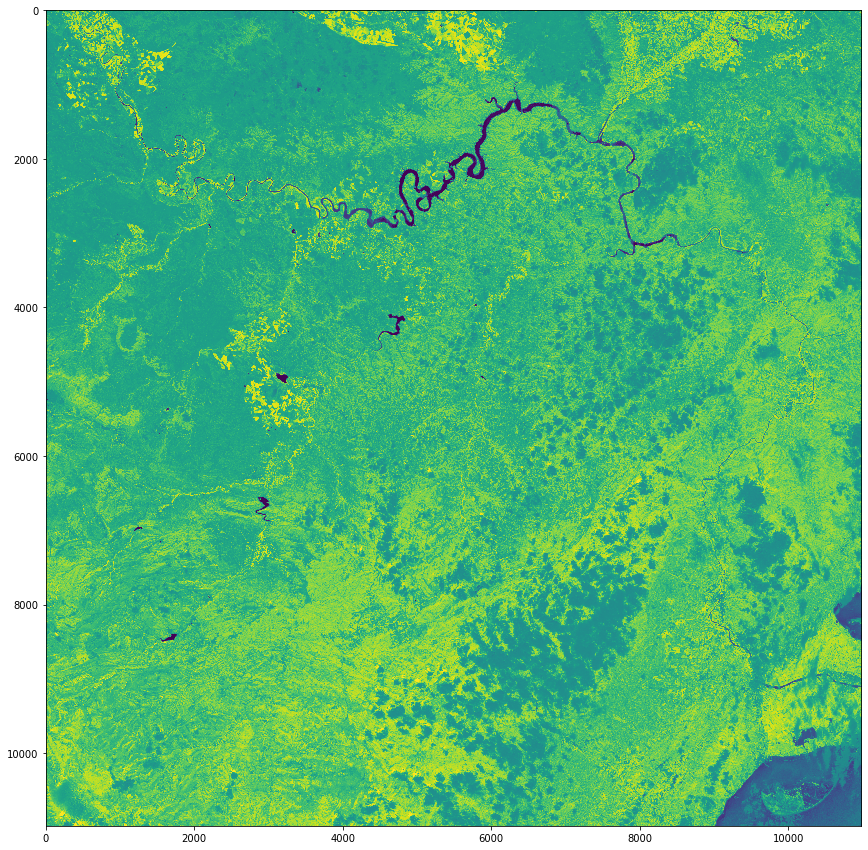

In [29]:
obj = cloud_storage.get_object(bucket=STORAGE_BUCKET, key=tile_select.value, stream=True)

fig, axs = plt.subplots(figsize=(20,15))

with rasterio.open(obj) as src:
#     ij, window = random.choice(list(src.block_windows()))
#     arr = src.read(1, window=window)
    arr = src.read(1)
    plt.imshow(arr)